In [1]:
# [0] Environment & Device Setup

import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


c:\Users\lsg-yy\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\__init__.py:169: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Device: cuda


In [ ]:
# [1] Load Preprocessed Torch Datasets

dataset_dir = "torch_datasets"

train_dataset_path = os.path.join(dataset_dir, "train_dataset_recovered.pt")
test_dataset_path  = os.path.join(dataset_dir, "test_dataset_recovered.pt")

train_dataset: TensorDataset = torch.load(
    train_dataset_path,
    map_location="cpu", 
    weights_only=False,
)
test_dataset: TensorDataset = torch.load(
    test_dataset_path,
    map_location="cpu", 
    weights_only=False,
)

print("Loaded train dataset from:", train_dataset_path)
print("Loaded test  dataset from:", test_dataset_path)


Loaded train dataset from: torch_datasets\train_dataset_recovered.pt
Loaded test  dataset from: torch_datasets\test_dataset_recovered.pt


In [3]:
# [2] Inspect Dataset Structure

X_train, y_train = train_dataset.tensors
X_test,  y_test  = test_dataset.tensors

print("X_train:", X_train.shape, "| device:", X_train.device, "| dtype:", X_train.dtype)
print("y_train:", y_train.shape, "| device:", y_train.device, "| dtype:", y_train.dtype)
print("X_test :", X_test.shape,  "| device:", X_test.device,  "| dtype:", X_test.dtype)
print("y_test :", y_test.shape,  "| device:", y_test.device,  "| dtype:", y_test.dtype)

print("Label counts (train):", torch.bincount(y_train).tolist())
print("Label counts (test) :", torch.bincount(y_test).tolist())


X_train: torch.Size([4665, 1, 22, 1001]) | device: cpu | dtype: torch.float32
y_train: torch.Size([4665]) | device: cpu | dtype: torch.int64
X_test : torch.Size([519, 1, 22, 1001]) | device: cpu | dtype: torch.float32
y_test : torch.Size([519]) | device: cpu | dtype: torch.int64
Label counts (train): [1166, 1167, 1166, 1166]
Label counts (test) : [130, 129, 130, 130]


In [ ]:
# [3] Create DataLoaders for Training & Evaluation

batch_size = 64
num_workers = 0

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=(device.type == "cuda"), 
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=(device.type == "cuda"),
)

print("Train batches:", len(train_loader))
print("Test  batches:", len(test_loader))


Train batches: 73
Test  batches: 9


In [5]:
# [4] Quick Sanity Check: One Batch Sample

batch_X, batch_y = next(iter(train_loader))
print("Batch X:", batch_X.shape, "| device:", batch_X.device)
print("Batch y:", batch_y.shape, "| device:", batch_y.device)


Batch X: torch.Size([64, 1, 22, 1001]) | device: cpu
Batch y: torch.Size([64]) | device: cpu


In [ ]:
# [5] TCFormer-like Model Definition (Multi-kernel CNN + Transformer + TCN)

class CausalConv1d(nn.Conv1d):
    def __init__(self, in_channels, out_channels, kernel_size, dilation=1, groups=1, bias=True):
        self._pad = (kernel_size - 1) * dilation
        super().__init__(in_channels, out_channels, kernel_size,
                         padding=self._pad, dilation=dilation, groups=groups, bias=bias)

    def forward(self, x):
        y = super().forward(x)
        if self._pad > 0:
            return y[..., :-self._pad]
        return y


class Conv1dWithConstraint(nn.Conv1d):
    def __init__(self, in_channels, out_channels, kernel_size, groups=1, max_norm=None, bias=True):
        super().__init__(in_channels, out_channels, kernel_size, groups=groups, bias=bias)
        self.max_norm = max_norm

    def forward(self, x):
        if self.max_norm is not None:
            with torch.no_grad():
                w = self.weight.view(self.out_channels, -1)
                norms = w.norm(dim=1, keepdim=True)
                desired = torch.clamp(norms, max=self.max_norm)
                self.weight.data *= (desired / (1e-8 + norms)).view(self.out_channels, 1, 1)
        return super().forward(x)


class TCNBlock(nn.Module):
    def __init__(self, kernel_length=4, n_filters=32, dilation=1, n_groups=1, dropout=0.3):
        super().__init__()
        self.conv1 = CausalConv1d(n_filters, n_filters, kernel_size=kernel_length,
                                  dilation=dilation, groups=n_groups, bias=True)
        self.bn1 = nn.BatchNorm1d(n_filters)
        self.conv2 = CausalConv1d(n_filters, n_filters, kernel_size=kernel_length,
                                  dilation=dilation, groups=n_groups, bias=True)
        self.bn2 = nn.BatchNorm1d(n_filters)
        self.drop1 = nn.Dropout(dropout)
        self.drop2 = nn.Dropout(dropout)
        self.act = nn.ELU()

        nn.init.constant_(self.conv1.bias, 0.0)
        nn.init.constant_(self.conv2.bias, 0.0)

    def forward(self, x):
        y = self.conv1(x)
        y = self.bn1(y)
        y = self.act(y)
        y = self.drop1(y)

        y = self.conv2(y)
        y = self.bn2(y)
        y = self.act(y)
        y = self.drop2(y)

        return self.act(x + y)


class TCN(nn.Module):
    def __init__(self, depth=2, kernel_length=4, n_filters=32, n_groups=1, dropout=0.3):
        super().__init__()
        blocks = []
        for i in range(depth):
            dilation = 2 ** i
            blocks.append(TCNBlock(kernel_length, n_filters, dilation, n_groups, dropout))
        self.blocks = nn.ModuleList(blocks)

    def forward(self, x):
        for blk in self.blocks:
            x = blk(x)
        return x


class ClassificationHead(nn.Module):
    def __init__(self, d_features, n_groups, n_classes, kernel_size=1, max_norm=0.25):
        super().__init__()
        self.n_groups = n_groups
        self.n_classes = n_classes
        self.linear = Conv1dWithConstraint(
            in_channels=d_features,
            out_channels=n_classes * n_groups,
            kernel_size=kernel_size,
            groups=n_groups,
            max_norm=max_norm,
            bias=True,
        )

    def forward(self, x):
        x = self.linear(x).squeeze(-1)          # [B, n_classes * n_groups]
        x = x.view(x.size(0), self.n_groups, self.n_classes).mean(dim=1)
        return x                                # [B, n_classes]


class TCNHead(nn.Module):
    def __init__(self, d_features=64, n_groups=1, tcn_depth=2,
                 kernel_length=4, dropout_tcn=0.3, n_classes=4):
        super().__init__()
        self.tcn = TCN(tcn_depth, kernel_length, d_features, n_groups, dropout_tcn)
        self.classifier = ClassificationHead(
            d_features=d_features,
            n_groups=n_groups,
            n_classes=n_classes,
        )

    def forward(self, x):
        x = self.tcn(x)              # [B, d_features, T]
        x = x[:, :, -1:].contiguous()
        x = self.classifier(x)
        return x


class MultiKernelConvBlock(nn.Module):
    def __init__(
        self,
        n_channels,
        temp_kernel_lengths=(16, 32, 64),
        F1=16,
        D=2,
        pool_length_1=8,
        pool_length_2=7,
        dropout=0.3,
        d_group=16,
        use_group_attn=False,
    ):
        super().__init__()
        self.n_groups = len(temp_kernel_lengths)
        self.rearrange = None

        self.temporal_convs = nn.ModuleList([
            nn.Sequential(
                nn.ConstantPad2d(
                    (k // 2 - 1, k // 2, 0, 0) if k % 2 == 0 else (k // 2, k // 2, 0, 0),
                    0.0,
                ),
                nn.Conv2d(1, F1, (1, k), bias=False),
                nn.BatchNorm2d(F1),
            )
            for k in temp_kernel_lengths
        ])

        self.d_model = d_group * self.n_groups
        self.use_channel_reduction_1 = False

        F2 = F1 * self.n_groups * D
        self.channel_DW_conv = nn.Sequential(
            nn.Conv2d(F1 * self.n_groups, F2, (n_channels, 1),
                      bias=False, groups=F1 * self.n_groups),
            nn.BatchNorm2d(F2),
            nn.ELU(),
        )
        self.pool1 = nn.AvgPool2d((1, pool_length_1))
        self.drop1 = nn.Dropout(dropout)

        self.use_channel_reduction_2 = (self.d_model != F2)
        if self.use_channel_reduction_2:
            self.channel_reduction_2 = nn.Sequential(
                nn.Conv2d(F2, self.d_model, (1, 1),
                          bias=False, groups=self.n_groups),
                nn.BatchNorm2d(self.d_model),
            )

        self.temporal_conv_2 = nn.Sequential(
            nn.Conv2d(self.d_model, self.d_model, (1, 16),
                      padding="same", bias=False, groups=self.n_groups),
            nn.BatchNorm2d(self.d_model),
            nn.ELU(),
        )

        self.use_group_attn = False
        self.pool2 = nn.AvgPool2d((1, pool_length_2))
        self.drop2 = nn.Dropout(dropout)

    def forward(self, x):
        x = x.unsqueeze(1)  # [B, 1, C, T]
        feats = [conv(x) for conv in self.temporal_convs]
        x = torch.cat(feats, dim=1)  # [B, F1*n_groups, C, T]

        x = self.channel_DW_conv(x)
        x = self.pool1(x)
        x = self.drop1(x)

        if self.use_channel_reduction_2:
            x = self.channel_reduction_2(x)

        x = self.temporal_conv_2(x)
        x = self.pool2(x)
        x = self.drop2(x)

        x = x.squeeze(2)  # [B, d_model, T_reduced]
        return x


def _build_rotary_cache(head_dim, seq_len, device):
    theta = 1.0 / (10000 ** (torch.arange(0, head_dim, 2, device=device).float() / head_dim))
    seq_idx = torch.arange(seq_len, device=device).float()
    freqs = torch.outer(seq_idx, theta)
    emb = torch.cat((freqs, freqs), dim=-1)
    cos, sin = emb.cos(), emb.sin()
    return cos, sin


def _rope(q, k, cos, sin):
    def _rotate(x):
        x1, x2 = x[..., ::2], x[..., 1::2]
        return torch.stack((-x2, x1), dim=-1).reshape_as(x)

    q_out = q * cos + _rotate(q) * sin
    k_out = k * cos + _rotate(k) * sin
    return q_out, k_out


def _xavier_zero_bias(module):
    for m in module.modules():
        if isinstance(m, (nn.Conv1d, nn.Conv2d, nn.Linear)):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)


class DropPath(nn.Module):
    def __init__(self, drop_prob=0.0):
        super().__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        if self.drop_prob == 0.0 or not self.training:
            return x
        keep_prob = 1.0 - self.drop_prob
        shape = (x.shape[0],) + (1,) * (x.ndim - 1)
        random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
        random_tensor.floor_()
        return x.div(keep_prob) * random_tensor


class _GQAttention(nn.Module):
    def __init__(self, d_model, num_q_heads, num_kv_heads, dropout=0.3):
        super().__init__()
        assert d_model % num_q_heads == 0
        assert num_q_heads % num_kv_heads == 0
        self.num_q_heads = num_q_heads
        self.num_kv_heads = num_kv_heads
        self.head_dim = d_model // num_q_heads
        self.scale = self.head_dim ** -0.5

        self.q_proj = nn.Linear(d_model, d_model, bias=False)
        self.kv_proj = nn.Linear(d_model, 2 * num_kv_heads * self.head_dim, bias=False)
        self.o_proj = nn.Linear(d_model, d_model, bias=False)
        self.drop = nn.Dropout(dropout)

        _xavier_zero_bias(self)

    def forward(self, x, cos, sin):
        B, T, C = x.shape
        q = self.q_proj(x).view(B, T, self.num_q_heads, self.head_dim).transpose(1, 2)
        kv = self.kv_proj(x).view(B, T, self.num_kv_heads, 2, self.head_dim)
        k = kv[..., 0, :].transpose(1, 2)
        v = kv[..., 1, :].transpose(1, 2)

        repeat_factor = self.num_q_heads // self.num_kv_heads
        k = k.repeat_interleave(repeat_factor, dim=1)
        v = v.repeat_interleave(repeat_factor, dim=1)

        cos = cos[:T, :].unsqueeze(0).unsqueeze(0)
        sin = sin[:T, :].unsqueeze(0).unsqueeze(0)
        q, k = _rope(q, k, cos, sin)

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.drop(attn)
        out = attn @ v
        out = out.transpose(1, 2).contiguous().view(B, T, C)
        return self.o_proj(out)


class _TransformerBlock(nn.Module):
    def __init__(self, d_model, q_heads, kv_heads,
                 mlp_ratio=2, dropout=0.4, drop_path_rate=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(d_model)
        self.attn = _GQAttention(d_model, q_heads, kv_heads, dropout)
        self.drop_path = DropPath(drop_path_rate)
        self.norm2 = nn.LayerNorm(d_model)
        self.mlp = nn.Sequential(
            nn.Linear(d_model, mlp_ratio * d_model),
            nn.GELU(),
            nn.Linear(mlp_ratio * d_model, d_model),
            nn.Dropout(dropout),
        )

    def forward(self, x, cos, sin):
        x = x + self.drop_path(self.attn(self.norm1(x), cos, sin))
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x


class TCFormerModule(nn.Module):
    def __init__(
        self,
        n_channels,
        n_classes,
        F1=16,
        temp_kernel_lengths=(16, 32, 64),
        pool_length_1=8,
        pool_length_2=7,
        D=2,
        dropout_conv=0.3,
        d_group=16,
        tcn_depth=2,
        kernel_length_tcn=4,
        dropout_tcn=0.3,
        use_group_attn=False,
        q_heads=8,
        kv_heads=4,
        trans_depth=5,
        trans_dropout=0.4,
        drop_path_max=0.25,
    ):
        super().__init__()
        self.n_classes = n_classes
        self.n_groups = len(temp_kernel_lengths)
        self.d_model = d_group * self.n_groups

        self.conv_block = MultiKernelConvBlock(
            n_channels=n_channels,
            temp_kernel_lengths=temp_kernel_lengths,
            F1=F1,
            D=D,
            pool_length_1=pool_length_1,
            pool_length_2=pool_length_2,
            dropout=dropout_conv,
            d_group=d_group,
            use_group_attn=use_group_attn,
        )

        self.mix = nn.Sequential(
            nn.Conv1d(self.d_model, self.d_model, kernel_size=1,
                      groups=1, bias=False),
            nn.BatchNorm1d(self.d_model),
            nn.SiLU(),
        )

        drop_rates = torch.linspace(0, 1, trans_depth) ** 2 * drop_path_max
        self.register_buffer("_cos", None, persistent=False)
        self.register_buffer("_sin", None, persistent=False)

        self.transformer = nn.ModuleList([
            _TransformerBlock(self.d_model, q_heads, kv_heads,
                              dropout=trans_dropout,
                              drop_path_rate=drop_rates[i].item())
            for i in range(trans_depth)
        ])

        self.reduce = nn.Sequential(
            nn.Conv1d(self.d_model, d_group, kernel_size=1,
                      groups=1, bias=False),
            nn.BatchNorm1d(d_group),
            nn.SiLU(),
        )

        self.tcn_head = TCNHead(
            d_features=d_group * (self.n_groups + 1),
            n_groups=(self.n_groups + 1),
            tcn_depth=tcn_depth,
            kernel_length=kernel_length_tcn,
            dropout_tcn=dropout_tcn,
            n_classes=n_classes,
        )

    def _rotary_cache(self, seq_len, device):
        head_dim = self.transformer[0].attn.head_dim
        if self._cos is None or self._cos.shape[0] < seq_len:
            cos, sin = _build_rotary_cache(head_dim, seq_len, device)
            self._cos, self._sin = cos.to(device), sin.to(device)
        return self._cos, self._sin

    def forward(self, x):
        conv_features = self.conv_block(x)         # [B, d_model, T']
        mixed = self.mix(conv_features)            # [B, d_model, T']
        tokens = mixed.permute(0, 2, 1)            # [B, T', d_model]

        T = tokens.size(1)
        cos, sin = self._rotary_cache(T, tokens.device)

        for blk in self.transformer:
            tokens = blk(tokens, cos, sin)

        tokens_t = tokens.permute(0, 2, 1)        # [B, d_model, T']
        tran_features = self.reduce(tokens_t)     # [B, d_group, T']

        features = torch.cat((conv_features, tran_features), dim=1)
        out = self.tcn_head(features)             # [B, n_classes]
        return out


class TCFormer(nn.Module):
    def __init__(self, n_channels, n_classes, **kwargs):
        super().__init__()
        self.net = TCFormerModule(n_channels=n_channels, n_classes=n_classes, **kwargs)

    def forward(self, x):
        x = x.squeeze(1)      # [B, 22, T]
        return self.net(x)


def summarize_model(model, input_shape, device):
    model = model.to(device)
    model.eval()
    x = torch.randn(*((1,) + input_shape), device=device)
    with torch.no_grad():
        out = model(x)
    n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(model)
    print(f"Input shape : {tuple(x.shape)}")
    print(f"Output shape: {tuple(out.shape)}")
    print(f"Trainable parameters: {n_params:,}")


In [7]:
# [6] Training & Evaluation Utilities

def run_epoch(model, loader, criterion, device, train=True, optimizer=None):
    if train:
        model.train()
    else:
        model.eval()

    total_loss = 0.0
    correct = 0
    total = 0

    with torch.set_grad_enabled(train):
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            if train:
                optimizer.zero_grad()

            logits = model(x)
            loss = criterion(logits, y)

            if train:
                loss.backward()
                optimizer.step()

            bs = y.size(0)
            total_loss += loss.item() * bs
            preds = logits.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += bs

    avg_loss = total_loss / total
    avg_acc = correct / total
    return avg_loss, avg_acc


In [8]:
# [7] Train TCFormer Model

import copy

num_classes = 4
model = TCFormer(
    n_channels=22,
    n_classes=num_classes,
    F1=16,
    temp_kernel_lengths=(16, 32, 64),
    pool_length_1=8,
    pool_length_2=7,
    D=2,
    dropout_conv=0.3,
    d_group=16,
    tcn_depth=2,
    kernel_length_tcn=4,
    dropout_tcn=0.3,
    use_group_attn=False,
    q_heads=8,
    kv_heads=4,
    trans_depth=5,
    trans_dropout=0.4,
).to(device)

input_shape = (1, 22, X_train.shape[-1])
print("===== TCFormer Summary =====")
summarize_model(model, input_shape, device)
print("============================\n")

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

num_epochs = 100
train_loss_hist, test_loss_hist = [], []
train_acc_hist, test_acc_hist = [], []

best_train_loss = float("inf")
best_train_acc = 0.0
best_test_loss = float("inf")
best_test_acc = 0.0
best_state_dict = copy.deepcopy(model.state_dict())

for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = run_epoch(
        model, train_loader, criterion, device, train=True, optimizer=optimizer
    )
    test_loss, test_acc = run_epoch(
        model, test_loader, criterion, device, train=False
    )

    train_loss_hist.append(train_loss)
    test_loss_hist.append(test_loss)
    train_acc_hist.append(train_acc)
    test_acc_hist.append(test_acc)

    if train_loss < best_train_loss:
        best_train_loss = train_loss
        best_train_acc = train_acc

    if test_loss < best_test_loss:
        best_test_loss = test_loss
        best_test_acc = test_acc
        best_state_dict = copy.deepcopy(model.state_dict())

    print(
        f"Epoch {epoch:03d} | "
        f"Train Loss: {train_loss:.4f} Acc: {train_acc*100:.2f}% | "
        f"Test Loss: {test_loss:.4f} Acc: {test_acc*100:.2f}%"
    )

print("\n===== Best Results (by Test Loss) =====")
print(f"Best Train Loss: {best_train_loss:.4f}")
print(f"Best Train Acc : {best_train_acc*100:.2f}%")
print(f"Best Test Loss : {best_test_loss:.4f}")
print(f"Best Test Acc  : {best_test_acc*100:.2f}%")
print("=======================================)")


===== TCFormer Summary =====
TCFormer(
  (net): TCFormerModule(
    (conv_block): MultiKernelConvBlock(
      (temporal_convs): ModuleList(
        (0): Sequential(
          (0): ConstantPad2d(padding=(7, 8, 0, 0), value=0.0)
          (1): Conv2d(1, 16, kernel_size=(1, 16), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): Sequential(
          (0): ConstantPad2d(padding=(15, 16, 0, 0), value=0.0)
          (1): Conv2d(1, 16, kernel_size=(1, 32), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (2): Sequential(
          (0): ConstantPad2d(padding=(31, 32, 0, 0), value=0.0)
          (1): Conv2d(1, 16, kernel_size=(1, 64), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (channel_DW_conv): Sequential(
    

c:\Users\lsg-yy\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\conv.py:549: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\Convolution.cpp:1037.)
  return F.conv2d(



Input shape : (1, 1, 22, 1001)
Output shape: (1, 4)
Trainable parameters: 121,152

Epoch 001 | Train Loss: 1.3765 Acc: 28.06% | Test Loss: 1.3488 Acc: 31.21%
Epoch 002 | Train Loss: 1.3323 Acc: 34.06% | Test Loss: 1.3043 Acc: 38.73%
Epoch 003 | Train Loss: 1.3012 Acc: 37.45% | Test Loss: 1.2722 Acc: 40.46%
Epoch 004 | Train Loss: 1.2448 Acc: 42.64% | Test Loss: 1.1923 Acc: 47.78%
Epoch 005 | Train Loss: 1.1935 Acc: 45.47% | Test Loss: 1.1934 Acc: 44.51%
Epoch 006 | Train Loss: 1.1610 Acc: 47.78% | Test Loss: 1.1321 Acc: 50.10%
Epoch 007 | Train Loss: 1.1355 Acc: 48.64% | Test Loss: 1.0929 Acc: 51.06%
Epoch 008 | Train Loss: 1.1170 Acc: 49.52% | Test Loss: 1.0984 Acc: 49.71%
Epoch 009 | Train Loss: 1.0928 Acc: 51.68% | Test Loss: 1.0484 Acc: 53.76%
Epoch 010 | Train Loss: 1.0877 Acc: 51.30% | Test Loss: 1.0370 Acc: 53.37%
Epoch 011 | Train Loss: 1.0582 Acc: 52.90% | Test Loss: 1.0304 Acc: 53.18%
Epoch 012 | Train Loss: 1.0490 Acc: 53.42% | Test Loss: 1.0346 Acc: 55.88%
Epoch 013 | Trai

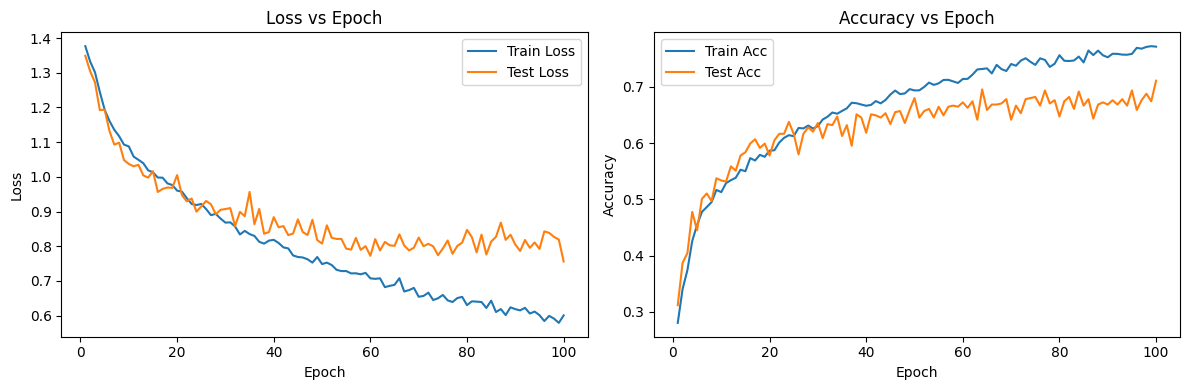

In [9]:
# [8] Plot Training & Test Curves

epochs = np.arange(1, num_epochs + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_hist, label="Train Loss")
plt.plot(epochs, test_loss_hist, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc_hist, label="Train Acc")
plt.plot(epochs, test_acc_hist, label="Test Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epoch")
plt.legend()

plt.tight_layout()
plt.show()


Using best model parameters:
Best Test Loss : 0.7561
Best Test Acc  : 71.10%

Class 0: Acc = 62.31% (support=130)
Class 1: Acc = 75.97% (support=129)
Class 2: Acc = 76.15% (support=130)
Class 3: Acc = 70.00% (support=130)

Confusion Matrix (counts):
[[81 24 17  8]
 [ 5 98 14 12]
 [ 9  8 99 14]
 [ 4 15 20 91]]

Confusion Matrix (% per true class):
[[62.3 18.5 13.1  6.2]
 [ 3.9 76.  10.9  9.3]
 [ 6.9  6.2 76.2 10.8]
 [ 3.1 11.5 15.4 70. ]]


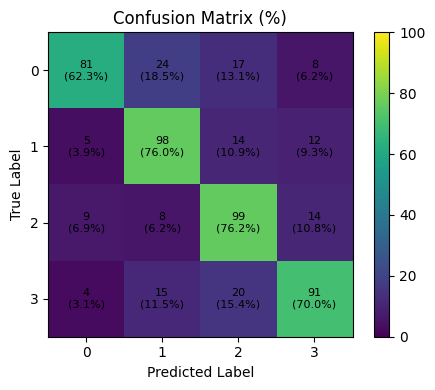

In [10]:
# [9] Final Evaluation: Per-Class Accuracy & Confusion Matrix (%)

model.load_state_dict(best_state_dict)
model.eval()

print("Using best model parameters:")
print(f"Best Test Loss : {best_test_loss:.4f}")
print(f"Best Test Acc  : {best_test_acc*100:.2f}%\n")

all_preds = []
all_labels = []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        y = y.to(device)
        logits = model(x)
        preds = logits.argmax(dim=1)
        all_preds.append(preds.cpu())
        all_labels.append(y.cpu())

all_preds = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()

cm = confusion_matrix(all_labels, all_preds, labels=np.arange(num_classes))
cm_sum = cm.sum(axis=1, keepdims=True)
cm_percent = np.divide(
    cm, cm_sum, out=np.zeros_like(cm, dtype=float), where=cm_sum != 0
) * 100.0

for c in range(num_classes):
    mask = (all_labels == c)
    acc_c = (all_preds[mask] == c).mean() if mask.sum() > 0 else 0.0
    print(f"Class {c}: Acc = {acc_c*100:.2f}% (support={mask.sum()})")

print("\nConfusion Matrix (counts):")
print(cm)

print("\nConfusion Matrix (% per true class):")
print(np.round(cm_percent, 1))

plt.figure(figsize=(5, 4))
im = plt.imshow(cm_percent, interpolation="nearest", vmin=0, vmax=100)
plt.title("Confusion Matrix (%)")
plt.colorbar(im)
ticks = np.arange(num_classes)
plt.xticks(ticks, ticks)
plt.yticks(ticks, ticks)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

for i in range(num_classes):
    for j in range(num_classes):
        text = f"{cm[i, j]}\n({cm_percent[i, j]:.1f}%)"
        plt.text(j, i, text, ha="center", va="center", fontsize=8)

plt.tight_layout()
plt.show()


In [ ]:
# [10] Save TCFormer state_dict(.pth) + Minimal Config for External / ROS2 Use

import json
from pathlib import Path

# 0) 체크포인트 저장 디렉토리 생성
ckpt_dir = Path("checkpoints_tcformer")
ckpt_dir.mkdir(parents=True, exist_ok=True)

state_path  = ckpt_dir / "tcformer_state_dict.pth"
config_path = ckpt_dir / "tcformer_config.json"

# 1) Best 모델 파라미터 저장
torch.save(best_state_dict, state_path)
print("Saved TCFormer state_dict to:", state_path)

# 2) 재사용에 필요한 설정값 저장
config = {
    "n_channels": 22,
    "n_classes": num_classes,
    "model_args": {
        "F1": 16,
        "temp_kernel_lengths": [16, 32, 64],
        "pool_length_1": 8,
        "pool_length_2": 7,
        "D": 2,
        "dropout_conv": 0.3,
        "d_group": 16,
        "tcn_depth": 2,
        "kernel_length_tcn": 4,
        "dropout_tcn": 0.3,
        "use_group_attn": False,
        "q_heads": 8,
        "kv_heads": 4,
        "trans_depth": 5,
        "trans_dropout": 0.4,
    },
    "input_shape": [1, 22, int(X_train.shape[-1])],  
}

with open(config_path, "w") as f:
    json.dump(config, f, indent=2)

print("Saved TCFormer config to :", config_path)



Saved TCFormer state_dict to: checkpoints_tcformer\tcformer_state_dict.pth
Saved TCFormer config to : checkpoints_tcformer\tcformer_config.json
